In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

## Variable Selection

There a few ways to go about variable selection with so many variables. Some include
- trees/RFs
- BMA
- random effects brms (with horseshoe/double exponential prior)

In this notebook, I first attempt a LASSO and random forest for one year, then try to take into account heterogeneity among states (or years) using a mixed-effects random forest. I look at the importances of the variables and use this information to remove relatively unimportant ones.


In [2]:
prison_df = pd.read_csv("Data/tidy_df.csv")
prison_2012 = prison_df.query("year==2012"). \
loc[:,prison_df.columns.str.contains("Female")==False]

prison_2012_shrt=prison_2012. \
filter(prison_2012.loc[:,prison_2012.columns.str.contains("16-18")==False]). \
drop(["CST-prop-Others-Male","IPC-prop-Unknown-Total 18-30 years", 
                  "IPC-prop-Unknown-Total 30-50 years", "IPC-prop-Unknown-Total Above 50 years",
                  "JWP-prop-Others", "JWP-prop-Women Jail","REL-prop-Others-Male",
                  "computer_course", "elementary_education",
                  "habitual_offenders","year","killed","area","incidence"],axis=1). \
assign(convict_prop = lambda df: df["convicts_admitted"]/df["pop_2011"]). \
drop(["convicts_admitted","pop_2011"],axis=1)

prison_2012_shrt

,state_name,recidiv_ratio,CST-prop-OBC-Male,CST-prop-SC-Male,CST-prop-ST-Male,SP-prop-life-Male-age_18_30_years,SP-prop-light-Male-age_18_30_years,SP-prop-long-Male-age_18_30_years,SP-prop-med-Male-age_18_30_years,SP-prop-life-Male-age_30_50_years,...,adult_education,higher_education,inmates_trained,financial_assistance_provided,rehabilitated,legal_aid_provided,injured,region,dens,convict_prop
11,Andhra Pradesh,0.136907,0.241423,0.189750,0.094452,0.205845,0.056120,0.024142,0.037061,0.368488,...,19539,514,1993.0,79,31,2402,0,Southern,308.272520,0.000196
15,Arunachal Pradesh,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.750000,0.000000,0.000000,...,0,0,7.0,0,0,6,0,Northeastern,16.510168,0.000007
28,Assam,0.058550,0.260252,0.196215,0.148265,0.124606,0.026183,0.116088,0.020189,0.323344,...,1423,51,267.0,196,99,22,0,Northeastern,397.374640,0.000069
41,Bihar,0.008611,0.495618,0.136319,0.045521,0.138997,0.020204,0.076193,0.029455,0.330088,...,2871,12,1878.0,76,1,563,17,North Central,1102.392978,0.000077
43,Chhattisgarh,0.017421,0.333836,0.211100,0.301811,0.257545,0.016767,0.109323,0.026157,0.298793,...,839,239,1040.0,5,0,1261,0,Central,188.919351,0.000139
66,Goa,0.029630,0.117647,0.051471,0.066176,0.169118,0.044118,0.125000,0.066176,0.250000,...,0,6,117.0,7,34,241,0,Western,393.766343,0.000093
79,Gujarat,0.000000,0.301145,0.165731,0.212666,0.086234,0.036829,0.131148,0.035257,0.255333,...,2082,1348,5737.0,86,114,3370,0,Western,308.042015,0.000114
90,Haryana,0.023272,0.223996,0.251604,0.037756,0.184599,0.018206,0.156544,0.034472,0.213849,...,605,655,602.0,0,224,1747,15,Northern,582.490749,0.000170
103,Himachal Pradesh,0.000000,0.081933,0.303571,0.042017,0.087185,0.012605,0.153361,0.042017,0.226891,...,42,22,124.0,0,3,332,0,Northern,123.156809,0.000090
116,Jammu & Kashmir,0.002217,0.056555,0.151671,0.064267,0.133676,0.010283,0.089974,0.074550,0.321337,...,182,61,517.0,0,108,201,1,Northern,297.079283,0.000036


## LASSO

In [3]:
X = prison_2012_shrt.drop(["state_name","recidiv_ratio","region"],axis=1)
X_std = (X-X.mean())/X.std() 


Y= prison_2012_shrt["recidiv_ratio"]
Y_std = (Y-Y.mean())/Y.std()

In [4]:
from sklearn import linear_model

clf = linear_model.Lasso(alpha=0.8)
clf.fit(X_std,Y_std)

Lasso(alpha=0.8)

In [5]:
coefs = clf.coef_
#print(prison_2012_shrt.drop(["state_name","recidiv_ratio","region"],axis=1).loc[:,coefs!=0].columns)
print(coefs)

[ 0. -0.  0. -0.  0. -0.  0.  0.  0. -0. -0.  0.  0.  0.  0. -0. -0.  0.
 -0. -0.  0.  0. -0. -0. -0.  0. -0.  0.  0.  0. -0.  0.  0.  0.  0.  0.
 -0. -0.  0. -0.  0. -0.  0.  0. -0. -0.  0. -0.  0. -0.  0.  0.]


## Random Forest for One Year

In [6]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = \
train_test_split(X_std, Y_std, test_size=0.25,random_state=47)

In [7]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=1000, random_state=42)

rf.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=1000, random_state=42)

(array([2., 1., 0., 2., 0., 1., 0., 0., 0., 1.]),
 array([0.687801  , 0.7877648 , 0.88772861, 0.98769242, 1.08765622,
        1.18762003, 1.28758384, 1.38754764, 1.48751145, 1.58747525,
        1.68743906]),
 <BarContainer object of 10 artists>)

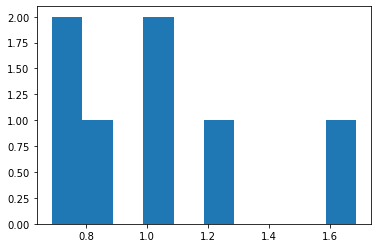

In [8]:
predictions = rf.predict(test_features)

errors = abs(predictions- test_labels)

plt.hist(errors)

In [9]:
importances=list(rf.feature_importances_)
feature_list = list(X.columns)
feature_importances = [(feature, round(importance,2)) for feature,
                       importance in zip(feature_list,importances)]

sorted(feature_importances, key = lambda x: x[1], reverse=True)

[('IPC-prop-Business-Total 18-30 years', 0.12),
 ('EDUC-prop-Graduate-Male', 0.09),
 ('CST-prop-SC-Male', 0.06),
 ('SP-prop-long-Male-age_18_30_years', 0.04),
 ('SP-prop-med-Male-age_18_30_years', 0.04),
 ('EDUC-prop-Illiterate-Male', 0.04),
 ('CST-prop-OBC-Male', 0.03),
 ('SP-prop-light-Male-age_18_30_years', 0.03),
 ('SP-prop-life-Male-age_30_50_years', 0.03),
 ('SP-prop-long-Male-age_30_50_years', 0.03),
 ('SP-prop-med-Male-age_50_above', 0.03),
 ('IPC-prop-Theft-Total 18-30 years', 0.03),
 ('IPC-prop-Violent-Total 30-50 years', 0.03),
 ('IPC-prop-Sexual-Total Above 50 years', 0.03),
 ('IPC-prop-Theft-Total Above 50 years', 0.03),
 ('CST-prop-ST-Male', 0.02),
 ('EDUC-prop-Below Class X-Male', 0.02),
 ('EDUC-prop-Holding technical degree/diploma etc-Male', 0.02),
 ('EDUC-prop-Post-Graduate-Male', 0.02),
 ('IPC-prop-Sexual-Total 18-30 years', 0.02),
 ('IPC-prop-Violent-Total Above 50 years', 0.02),
 ('JWP-prop-Special Jail', 0.02),
 ('JWP-prop-Sub_Jail', 0.02),
 ('dens', 0.02),
 ('SP-

## Mixed-Effect Random Forests
With the help of this blog post (https://towardsdatascience.com/mixed-effects-random-forests-6ecbb85cb177), I implement a mixed-effect random forest model used for longitudinal data. The fixed effects are modeled with a random forest, and the random effects are tacked on as a linear term along with homoskedastic error. 

I choose to include a random intercept by state and a random slope on year by state. A potential addition would be random intercept by year. If we were using this model for actual prediction, adding on an autoregressive term would be wise to model time dependency.


In [10]:
import merf

In [11]:
prison_df. \
filter(prison_df.loc[:,prison_df.columns.str.contains("Female")==False])

,state_name,year,convicts_admitted,habitual_offenders,recidiv_ratio,CST-prop-OBC-Male,CST-prop-Others-Male,CST-prop-SC-Male,CST-prop-ST-Male,SP-prop-life-Male-age_18_30_years,...,financial_assistance_provided,rehabilitated,legal_aid_provided,incidence,injured,killed,pop_2011,area,region,dens
0,Andhra Pradesh,2001,17345,1063,0.061286,0.361526,0.222459,0.292822,0.099029,0.149491,...,14,75,2594,0,0,0,49386799,160205,Southern,308.27252
1,Andhra Pradesh,2002,13322,318,0.023870,0.376232,0.272373,0.241585,0.078818,0.189245,...,37,108,1876,0,0,0,49386799,160205,Southern,308.27252
2,Andhra Pradesh,2003,15682,536,0.034179,0.442782,0.225763,0.224014,0.074024,0.177579,...,0,0,2126,0,0,0,49386799,160205,Southern,308.27252
3,Andhra Pradesh,2004,14397,399,0.027714,0.450367,0.252676,0.192655,0.062959,0.200000,...,0,0,909,0,0,0,49386799,160205,Southern,308.27252
4,Andhra Pradesh,2005,12389,977,0.078860,0.439234,0.261824,0.199960,0.059469,0.171822,...,0,204,2342,0,0,0,49386799,160205,Southern,308.27252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,West Bengal,2009,10890,2100,0.192837,0.067748,0.639635,0.141578,0.082615,0.093428,...,161,5,2920,1,6,0,91347736,88752,Eastern,1029.24707
314,West Bengal,2010,12150,1940,0.159671,0.105054,0.592246,0.141571,0.095189,0.062132,...,170,12,3020,1,2,0,91347736,88752,Eastern,1029.24707
315,West Bengal,2011,10259,1470,0.143289,0.056360,0.601943,0.132686,0.145053,0.097703,...,37,4,4057,3,36,0,91347736,88752,Eastern,1029.24707
316,West Bengal,2012,8650,1207,0.139538,0.074380,0.604764,0.159131,0.096257,0.106628,...,25,23,2583,7,14,0,91347736,88752,Eastern,1029.24707


As in the previous 2012-specific dataframe, I drop female-specific variables and reference variables, adding in density and convict proportion of population as new variables. Before splitting the data into a 0.75 -.25 train-test set, I standardize the numeric variables to allow for more stable estimates of random effects and a more stable random forest.

In [12]:
prison_shrt = prison_df.dropna(). \
filter(prison_df.loc[:,prison_df.columns.str.contains("Female")==False]). \
filter(prison_df.loc[:,prison_df.columns.str.contains("16-18")==False]). \
drop(["CST-prop-Others-Male","IPC-prop-Unknown-Total 18-30 years", 
                  "IPC-prop-Unknown-Total 30-50 years", "IPC-prop-Unknown-Total Above 50 years",
                  "JWP-prop-Others", "JWP-prop-Women Jail","REL-prop-Others-Male",
                  "computer_course", "elementary_education",
                  "habitual_offenders","killed","area","incidence", "region"],axis=1). \
assign(convict_prop = lambda df: df["convicts_admitted"]/df["pop_2011"]). \
drop(["convicts_admitted","pop_2011"],axis=1)

In [19]:
X = prison_shrt.drop(["recidiv_ratio"],axis=1)
X_std = pd.DataFrame((X-X.mean())/X.std()).assign(state_name=X["state_name"])
Y = prison_shrt["recidiv_ratio"]
Y_std = (Y-Y.mean())/Y.std()

from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = \
train_test_split(X_std, Y_std, test_size=0.25,random_state=47)

train_clusters = train_features["state_name"]
train_Z = np.transpose(np.array
             ([np.repeat(1,train_clusters.shape[0]),
               train_features["year"].to_numpy()]))
train_features = train_features.drop(["state_name", "year"], axis=1)

In [21]:
train_clusters

9       Andhra Pradesh
112    Jammu & Kashmir
304        Uttaranchal
127          Jharkhand
22               Assam
            ...       
23               Assam
185          Meghalaya
72             Gujarat
270            Tripura
140          Karnataka
Name: state_name, Length: 234, dtype: object

Giving the proper training set features, random effect specifications, and training labels, we run the MERF.

In [22]:
from merf.merf import MERF
mrf = MERF(max_iterations=200)
mrf.fit(train_features,train_Z,train_clusters,train_labels)

INFO     [merf.py:307] Training GLL is -365.996624127159 at iteration 1.
INFO     [merf.py:307] Training GLL is -557.8466072494773 at iteration 2.
INFO     [merf.py:307] Training GLL is -602.0199994357574 at iteration 3.
INFO     [merf.py:307] Training GLL is -572.824688287331 at iteration 4.
INFO     [merf.py:307] Training GLL is -581.8921505093563 at iteration 5.
INFO     [merf.py:307] Training GLL is -596.8554415438986 at iteration 6.
INFO     [merf.py:307] Training GLL is -608.3342770743386 at iteration 7.
INFO     [merf.py:307] Training GLL is -611.493762482915 at iteration 8.
INFO     [merf.py:307] Training GLL is -609.3700392552037 at iteration 9.
INFO     [merf.py:307] Training GLL is -618.3987180582579 at iteration 10.
INFO     [merf.py:307] Training GLL is -623.9649977299241 at iteration 11.
INFO     [merf.py:307] Training GLL is -620.5254675767976 at iteration 12.
INFO     [merf.py:307] Training GLL is -607.6438643802651 at iteration 13.
INFO     [merf.py:307] Training GLL i

INFO     [merf.py:307] Training GLL is -678.4673241407869 at iteration 111.
INFO     [merf.py:307] Training GLL is -659.5320416928993 at iteration 112.
INFO     [merf.py:307] Training GLL is -655.4242541107433 at iteration 113.
INFO     [merf.py:307] Training GLL is -654.4600392433641 at iteration 114.
INFO     [merf.py:307] Training GLL is -652.336176821006 at iteration 115.
INFO     [merf.py:307] Training GLL is -647.1178478344024 at iteration 116.
INFO     [merf.py:307] Training GLL is -662.1959132654365 at iteration 117.
INFO     [merf.py:307] Training GLL is -658.3730917022457 at iteration 118.
INFO     [merf.py:307] Training GLL is -654.9751579279986 at iteration 119.
INFO     [merf.py:307] Training GLL is -643.0056724185695 at iteration 120.
INFO     [merf.py:307] Training GLL is -649.5512517098688 at iteration 121.
INFO     [merf.py:307] Training GLL is -661.0278516312046 at iteration 122.
INFO     [merf.py:307] Training GLL is -649.9042375429499 at iteration 123.
INFO     [mer

The random effect estimated intercepts and slopes are below:

In [23]:
mrf.trained_b

,0,1
Madhya Pradesh,-0.072627,0.020957
Meghalaya,0.271291,-0.079794
Uttar Pradesh,-0.037550,0.010886
Punjab,-0.000365,-0.000956
Rajasthan,-0.030620,0.008827
Karnataka,-0.349077,0.101403
Chhattisgarh,-0.177586,0.052013
West Bengal,1.117611,-0.324689
Assam,-0.184069,0.053586
Haryana,-0.229520,0.066868


The random effect intercepts are roughly Gaussian (other than a few outliers) and centered around 0.

(array([4., 8., 7., 3., 2., 0., 0., 1., 0., 1.]),
 array([-0.4254446 , -0.271139  , -0.11683341,  0.03747218,  0.19177777,
         0.34608336,  0.50038895,  0.65469454,  0.80900013,  0.96330572,
         1.11761131]),
 <BarContainer object of 10 artists>)

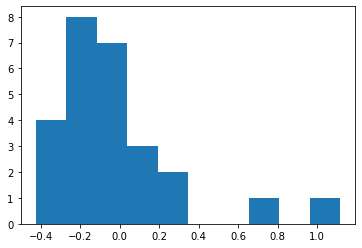

In [24]:
from merf.viz import plot_merf_training_stats

mrf.gll_history
plt.hist(mrf.trained_b[0])


When we look at estimated feature importance, we see that like in the previous simple random forest on one year, caste and sentence periods are relatively important while types of jails and rehabilitation efforts are not. However, this MERF also indicates that religion plays a larger and education a smaller role in being able to predict recidivism rates.

In [25]:
importances=list(mrf.trained_fe_model.feature_importances_)
feature_list = list(train_features.columns)
feature_importances = [(feature, round(importance,2)) for feature,
                       importance in zip(feature_list,importances)]

sorted(feature_importances, key = lambda x: x[1], reverse=True)

[('SP-prop-life-Male-age_50_above', 0.22),
 ('REL-prop-Muslim-Male', 0.11),
 ('SP-prop-med-Male-age_50_above', 0.06),
 ('convict_prop', 0.06),
 ('CST-prop-ST-Male', 0.05),
 ('REL-prop-Sikh-Male', 0.04),
 ('SP-prop-light-Male-age_18_30_years', 0.04),
 ('IPC-prop-Theft-Total 18-30 years', 0.03),
 ('CST-prop-OBC-Male', 0.02),
 ('EDUC-prop-Class X and above but below graduate-Male', 0.02),
 ('IPC-prop-Violent-Total 18-30 years', 0.02),
 ('REL-prop-Christian-Male', 0.02),
 ('REL-prop-Hindu-Male', 0.02),
 ('SP-prop-life-Male-age_30_50_years', 0.02),
 ('SP-prop-light-Male-age_30_50_years', 0.02),
 ('SP-prop-long-Male-age_18_30_years', 0.02),
 ('SP-prop-long-Male-age_30_50_years', 0.02),
 ('SP-prop-med-Male-age_18_30_years', 0.02),
 ('CST-prop-SC-Male', 0.01),
 ('EDUC-prop-Below Class X-Male', 0.01),
 ('EDUC-prop-Graduate-Male', 0.01),
 ('EDUC-prop-Illiterate-Male', 0.01),
 ('IPC-prop-Sexual-Total 30-50 years', 0.01),
 ('IPC-prop-Sexual-Total Above 50 years', 0.01),
 ('IPC-prop-Theft-Total 30-

(array([1., 0., 1., 0., 0., 2., 3., 7., 8., 4.]),
 array([-0.32468881, -0.27983844, -0.23498808, -0.19013771, -0.14528734,
        -0.10043697, -0.05558661, -0.01073624,  0.03411413,  0.0789645 ,
         0.12381486]),
 <BarContainer object of 10 artists>)

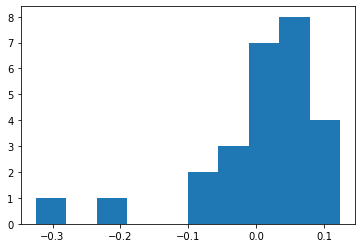

In [26]:
plt.hist(mrf.trained_b[1])